In [1]:
import matplotlib.patches as patches
from matplotlib import pyplot as plt
from matplotlib.ticker import ScalarFormatter
from sklearn import metrics

from dataset import get_dataset_class_number, get_num_samples
from utils import *

plt.style.use(['science', 'grid'])
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times"],
    "font.size": 11})


In [2]:
from copy import deepcopy


def read_data(data_path, method):
    results = []
    for name in os.listdir(data_path):
        path = os.path.join(data_path, name)
        if not os.path.isdir(path):
            continue
        # if not os.path.isfile(os.path.join(path, 'results_recog.json')):
        #     continue
        for epoch in range(0, 100, 5):
            with open(os.path.join(path, f'results_recog_{epoch}.json'), 'r') as f:
                res = json.load(f)
            with open(os.path.join(path, 'args.json'), 'r') as f:
                args = json.load(f)
            dic = res | args
            dic['path'] = path
            dic['cur_epoch'] = epoch
            dic['test_bound'] = abs(dic['test_bound']) * 0.01
            dic['test_error'] = 1 - dic['test_acc'] * 0.01
            
            results.append(dic)
    df = pd.DataFrame(results)
    df = df.loc[(df['method'] == method) & (df['ghost_dataset_name'].isnull())]
    df = df[['S_seed', 'seed',
             'num_samples', 'test_bound', 'test_error', 'path', 'cur_epoch']]
    # df['test_bound'] = 0.01 * df['test_bound']
    # df['test_error'] = 1 - df['test_acc'] * 0.01
    return df


def get_exp_res_dict(df):
    tmp_dict = {
        "test_bound": np.zeros([num_seeds]),
        "test_error": np.zeros([num_seeds]),
        "fcmi": np.zeros([num_seeds]),
        "recog": np.zeros([num_seeds]),
    }

    exp_res_dict = {ns: {ep: deepcopy(tmp_dict) for ep in range(0, 100, 5)} for ns in num_samples}
    for ns in num_samples:
        for epoch in range(0, 100, 5):
            for seed in range(num_seeds):
                df_exp = df.loc[(df['num_samples'] == ns) & (df['cur_epoch'] == epoch) &  (df['seed'] == seed)]
                exp_res_dict[ns][epoch]['test_bound'][seed] = df_exp['test_bound'].mean()
                exp_res_dict[ns][epoch]['test_error'][seed] = df_exp['test_error'].mean()
                
                preds = []
                masks = []
                probs = []
                path_dict = df_exp[['path', 'S_seed']].set_index('S_seed')['path'].to_dict()
                recog = 0
                for S_seed, path in path_dict.items():
                    pred_dict = load_prediction(f'preds_{epoch}.pkl', path)
                    preds.append(pred_dict['pred'])
                    masks.append(pred_dict['mask'])
                    probs.append(pred_dict['recog'])
                    auc = metrics.roc_auc_score(pred_dict['mask'], pred_dict['recog'])
                    recog += 1 - 2 * auc
                recog /= num_S_seeds
                fcmi_bound = estimate_fcmi_bound(preds, masks, num_classes, ns)
                exp_res_dict[ns][epoch]['fcmi'][seed] = fcmi_bound
                exp_res_dict[ns][epoch]['recog'][seed] = recog

    return exp_res_dict


In [19]:
def plot_mean_std(ax, res_dict, ns, key, label, marker):
    epochs = [epoch for epoch in range(0, 100, 5)]
    mean = np.array([np.mean((res_dict[ns][epoch][key])) for epoch in epochs])
    std = np.array([np.std((res_dict[ns][epoch][key])) for epoch in epochs])
    ax.plot(epochs, mean, label=label, lw=2,)
    ax.fill_between(epochs, mean - std, mean + std, alpha=0.2)


def plot(exp_res_dicts, legend=True, ylabel=True):
    cmap = plt.get_cmap("tab10")
 
    # recog_dict = {k: np.zeros([num_seeds]) for k in num_samples}
    # for idx, ns in enumerate(num_samples):
    #     for i in range(num_seeds):
    #         recog = 0
    #         for j in range(num_S_seeds):
    #             auc = metrics.roc_auc_score(exp_res_dicts['mask'][ns][i][j], exp_res_dicts['recog'][ns][i][j])
    #             recog += 1 - 2 * auc
    #         recog /= num_S_seeds
    #         recog_dict[ns][i] = recog

    # exp_res_dicts['recog_area'] = recog_dict
    for ns in num_samples:
        fig, ax = plt.subplots(figsize=(6, 4))
        plot_mean_std(ax, exp_res_dicts, ns, 'test_bound', 'gen. gap', 'o')
        plot_mean_std(ax, exp_res_dicts, ns, 'test_error', 'test error', '^')
        plot_mean_std(ax, exp_res_dicts, ns, 'fcmi', 'f-CMI bound', 'x')
        plot_mean_std(ax, exp_res_dicts, ns, 'recog', 'recognizability', 's')

        ax.set_xlabel('Epochs', size=26)
        if ylabel:
            ax.set_ylabel('Error', size=26)
        ax.tick_params(labelsize=24)
        # ax.set_xscale('log', base=2)
        # ax.xaxis.set_major_formatter(ScalarFormatter())
        ax.set_xticks([20*i for i in range(5)])
        if legend:
            ax.legend(fontsize=20).get_frame().set_alpha(0.5)
            
        fig.savefig(os.path.join(logdir, f'{dataset}_{ns}_epoch.pdf'), bbox_inches='tight', pad_inches=0)
        plt.show()


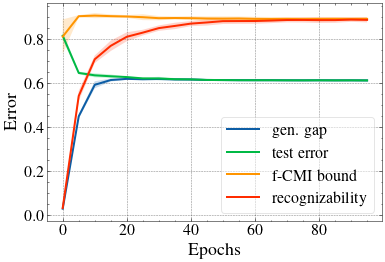

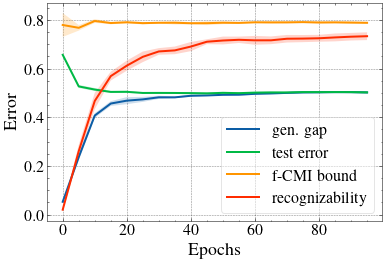

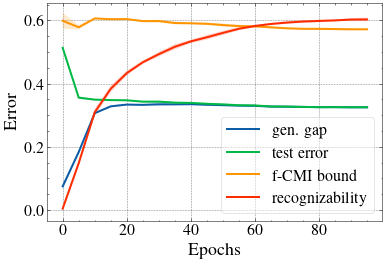

In [4]:
num_seeds = 5
num_S_seeds = 5
method = 'vanilla'
# logdir = '<your log dir>/my_cnn.CNN_my_mlp.MLP_seed_5_5_plot_dynamic/'
logdir = '<your data dir>/my_cnn.CNN_my_mlp.MLP_seed_5_5_plot_dynamic/'
datasets = ('cifar10',)

ds_dict = {}
for dataset in datasets:
    num_classes = get_dataset_class_number(dataset)
    num_samples = get_num_samples(dataset)
    data_path = os.path.join(logdir, dataset)
    df = read_data(data_path, method)
    exp_res_dicts = get_exp_res_dict(df)
    plot(exp_res_dicts, True, True)
    ds_dict[dataset] = exp_res_dicts


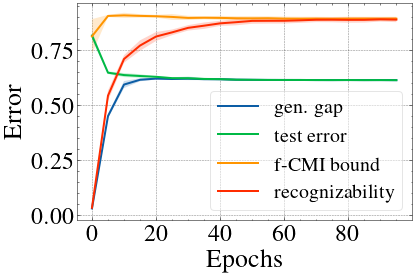

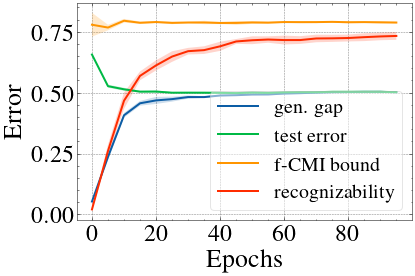

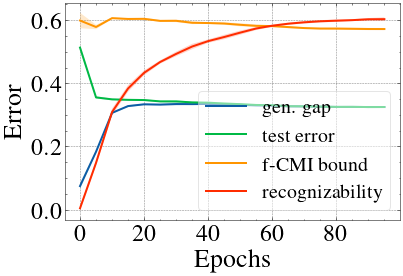

In [20]:
plot(exp_res_dicts, True, True)